In [182]:
import cv2
import numpy as np
import glob
from cvxopt import matrix,solvers
from scipy.spatial.distance import cdist,pdist,squareform
import multiprocessing
import random
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures

import matplotlib
matplotlib.style.use('ggplot')



# Part (a)

In [183]:
def preprocess(sample):
    sample =  (cv2.resize(sample, (16, 16), interpolation=cv2.INTER_CUBIC))/255.0
    return sample.flatten()

In [184]:
def read_sample(path):
    sample = cv2.imread(path)
    return preprocess(sample)

In [185]:
class0 = 2
class1 = 3

In [186]:
for iter, file in enumerate(glob.glob(f'./train/{class0}/*.jpg')):
    if iter == 0:
        print(file)
        X0 = read_sample(file)
    else:
        X0 = np.vstack((X0, read_sample(file)))

./train/2/190.jpg


In [187]:
X0.shape

(2380, 768)

In [188]:
regulising_factor = 1

In [189]:
for iter, file in enumerate(glob.glob(f'./train/{class1}/*.jpg')):
    if iter == 0:
        X1 = read_sample(file)
        print(file)
    else:
        X1 = np.vstack((X1, read_sample(file)))

./train/3/15970.jpg


In [190]:
X1.shape

(2380, 768)

In [191]:
X0

array([[0.80392157, 0.67843137, 0.58431373, ..., 0.5254902 , 0.31764706,
        0.14901961],
       [0.46666667, 0.48235294, 0.43921569, ..., 0.58431373, 0.62352941,
        0.55686275],
       [0.72941176, 0.5254902 , 0.36470588, ..., 0.16862745, 0.18039216,
        0.14509804],
       ...,
       [0.65882353, 0.61960784, 0.58039216, ..., 0.62352941, 0.60784314,
        0.54117647],
       [0.96470588, 0.89019608, 0.87058824, ..., 0.69803922, 0.66666667,
        0.60392157],
       [0.03921569, 0.06666667, 0.15294118, ..., 0.03921569, 0.03921569,
        0.09411765]])

In [192]:
-1*X0

array([[-0.80392157, -0.67843137, -0.58431373, ..., -0.5254902 ,
        -0.31764706, -0.14901961],
       [-0.46666667, -0.48235294, -0.43921569, ..., -0.58431373,
        -0.62352941, -0.55686275],
       [-0.72941176, -0.5254902 , -0.36470588, ..., -0.16862745,
        -0.18039216, -0.14509804],
       ...,
       [-0.65882353, -0.61960784, -0.58039216, ..., -0.62352941,
        -0.60784314, -0.54117647],
       [-0.96470588, -0.89019608, -0.87058824, ..., -0.69803922,
        -0.66666667, -0.60392157],
       [-0.03921569, -0.06666667, -0.15294118, ..., -0.03921569,
        -0.03921569, -0.09411765]])

In [193]:
only_X_data = np.vstack((X0, X1))

all_X = np.vstack((-1*X0, X1))
y = np.vstack((-1*np.ones((X0.shape[0], 1)), np.ones((X1.shape[0], 1))))

negative_test_cases = X0.shape[0]
positive_test_cases = X1.shape[0]
number_of_test_case = all_X.shape[0]

P = np.dot(all_X, all_X.T)
print(P.shape)

q = -1*np.ones((number_of_test_case, 1))
print(q.shape)
# q = q.T

# P = -1*P
# y

(4760, 4760)
(4760, 1)


In [194]:
G = np.vstack((-1*np.eye(number_of_test_case), np.eye(number_of_test_case)))
h = np.vstack((np.zeros((number_of_test_case, 1)), regulising_factor*np.ones((number_of_test_case, 1))))
print(G.shape, h.shape)

(9520, 4760) (9520, 1)


In [195]:
A =  np.hstack((-1*np.ones((1, negative_test_cases)), np.ones((1, positive_test_cases))))
print(A.shape)
b = np.zeros((1))

(1, 4760)


In [196]:
P = matrix(P, tc='d')
q = matrix(q, tc='d')
G = matrix(G, tc='d')
h = matrix(h, tc='d')
A = matrix(A, tc='d')
b = matrix(b, tc='d')

In [197]:
sol = solvers.qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0: -2.5650e+03 -1.4670e+04  8e+04  4e+00  6e-11
 1: -1.7385e+03 -1.0691e+04  2e+04  5e-01  7e-11
 2: -1.6061e+03 -3.7750e+03  2e+03  2e-02  5e-11
 3: -1.8341e+03 -2.4560e+03  6e+02  6e-03  5e-11
 4: -1.9304e+03 -2.2800e+03  4e+02  2e-03  5e-11
 5: -1.9866e+03 -2.1636e+03  2e+02  9e-04  5e-11
 6: -2.0164e+03 -2.1066e+03  9e+01  4e-04  5e-11
 7: -2.0355e+03 -2.0704e+03  4e+01  7e-05  6e-11
 8: -2.0451e+03 -2.0552e+03  1e+01  1e-05  6e-11
 9: -2.0478e+03 -2.0512e+03  3e+00  3e-06  6e-11
10: -2.0489e+03 -2.0497e+03  8e-01  6e-07  6e-11
11: -2.0492e+03 -2.0493e+03  9e-02  5e-08  6e-11
12: -2.0492e+03 -2.0492e+03  4e-03  2e-09  6e-11
13: -2.0492e+03 -2.0492e+03  9e-05  4e-11  6e-11
Optimal solution found.


In [198]:
solution = np.array(sol['x'])

## 1(a)

In [199]:
number_of_supp_vectors = np.sum(solution > 1e-3)
print(number_of_supp_vectors)

2337


In [200]:
linear_supp_vec = [1 if i > 1e-3 else 0 for i in solution]

In [201]:
solution_with_non_zero_alphas = solution.copy()
solution_with_non_zero_alphas[solution_with_non_zero_alphas < 1e-6] = 0

In [202]:
the_alphas = y*solution_with_non_zero_alphas
weights = np.dot(the_alphas.T, only_X_data).T
b = np.mean(y - np.dot(only_X_data,weights))

In [203]:
print("Weights: ", weights)
print("Bias: ", b)  

Weights:  [[-5.59072556e-01]
 [-1.49169460e-01]
 [ 1.93881225e-01]
 [-3.14146994e-01]
 [-1.26686179e-01]
 [ 6.34954734e-01]
 [ 5.11287575e-02]
 [ 1.35519238e-01]
 [-4.22894248e-01]
 [-7.93244697e-02]
 [ 3.64946569e-01]
 [-2.35435125e-01]
 [ 6.47204079e-02]
 [ 1.09788370e-01]
 [ 1.40917468e-01]
 [ 3.49449969e-02]
 [ 2.83997117e-01]
 [ 1.91653669e-01]
 [ 5.04257836e-01]
 [-2.90020999e-01]
 [-1.41657562e-01]
 [-8.60168516e-01]
 [-2.83811739e-01]
 [ 2.03160687e-01]
 [-3.64006617e-01]
 [ 9.27689856e-02]
 [ 3.66808147e-01]
 [ 4.21993792e-01]
 [ 1.38187731e-01]
 [-8.08899006e-01]
 [ 1.72034837e-01]
 [ 8.57126032e-02]
 [ 2.02503059e-01]
 [ 1.73132932e-01]
 [ 6.04787243e-02]
 [-5.83951154e-01]
 [ 9.71467817e-03]
 [ 5.39826618e-01]
 [ 2.81694021e-01]
 [ 2.71920109e-01]
 [ 4.27363754e-02]
 [-5.76486358e-01]
 [-1.15826278e-01]
 [ 6.76124192e-02]
 [ 3.49390914e-01]
 [-4.32863161e-01]
 [ 3.20628687e-02]
 [-8.97587267e-02]
 [ 2.98042489e-01]
 [ 2.16880753e-01]
 [ 4.82714080e-02]
 [ 5.21590200e-01]
 [

In [204]:
correct = 0
total = 0

for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    # print(validate_on.shape)
    if np.dot(validate_on, weights) + b <= 0:
        correct += 1
        
for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    if np.dot(validate_on, weights) + b >= 0:
        correct += 1

## 1(b)

In [205]:
print(f"Accuracy: {(100*correct)/total} %")

Accuracy: 78.0 %


## 1(c)

In [206]:
solution_vec = solution.T[0]
largest_alphas = np.argsort(solution_vec)[-6:]
x_is = only_X_data[largest_alphas]

for i, x in enumerate(x_is):
    img = x.reshape((16, 16, 3))

    img  = (img * 255).astype(np.uint8)
    filename = f'part_1_c_supports_{i}.png'
    cv2.imwrite(filename,img)
    

In [207]:
img = weights.T.reshape((16, 16, 3))
img = img/(sum(the_alphas)[0])

img  = (img * 255).astype(np.uint8)
filename = f'part_1_c_weight.png'
cv2.imwrite(filename,img)

True

## 2(a)

In [208]:
gamma = 0.001

In [209]:
KERNEL_MATRIX = (np.outer(y,y))* (np.exp(-gamma * cdist(only_X_data, only_X_data, 'sqeuclidean')))

# v = pdist(only_X_data, 'sqeuclidean')
# KERNEL_MATRIX = np.exp(-1*gamma*squareform(v))

q = -1*np.ones((number_of_test_case, 1))
G = np.vstack((-1*np.eye(number_of_test_case), np.eye(number_of_test_case)))
h = np.vstack((np.zeros((number_of_test_case, 1)), regulising_factor*np.ones((number_of_test_case, 1))))
print(G.shape, h.shape)
A =  np.hstack((-1*np.ones((1, negative_test_cases)), np.ones((1, positive_test_cases))))
# print(A.shape)
b = np.zeros((1))


(9520, 4760) (9520, 1)


In [210]:
KERNEL_MATRIX = matrix(KERNEL_MATRIX, tc='d')
q = matrix(q, tc='d')
G = matrix(G, tc='d')
h = matrix(h, tc='d')
A = matrix(A, tc='d')
b = matrix(b, tc='d')


In [211]:
kernel_sol = solvers.qp(KERNEL_MATRIX,q,G,h,A,b)
# only_X_data

     pcost       dcost       gap    pres   dres
 0: -2.8742e+03 -1.3658e+04  7e+04  3e+00  3e-13
 1: -1.9592e+03 -9.7113e+03  1e+04  2e-01  3e-13
 2: -2.0705e+03 -3.2563e+03  1e+03  2e-02  3e-13
 3: -2.3561e+03 -2.8430e+03  5e+02  7e-03  3e-13
 4: -2.4631e+03 -2.6992e+03  2e+02  3e-03  3e-13
 5: -2.5162e+03 -2.6295e+03  1e+02  1e-03  3e-13
 6: -2.5444e+03 -2.5932e+03  5e+01  4e-04  3e-13
 7: -2.5592e+03 -2.5748e+03  2e+01  1e-04  3e-13
 8: -2.5641e+03 -2.5688e+03  5e+00  2e-05  3e-13
 9: -2.5659e+03 -2.5666e+03  7e-01  3e-06  4e-13
10: -2.5662e+03 -2.5663e+03  2e-02  6e-08  4e-13
11: -2.5663e+03 -2.5663e+03  3e-04  1e-09  4e-13
Optimal solution found.


In [212]:
kernel_solution = np.array(kernel_sol['x'])

In [213]:
number_of_supp_vectors = np.sum(kernel_solution > 1e-3)
print(number_of_supp_vectors)

2788


In [214]:
gauss_supp_vec = [1 if i > 1e-3 else 0 for i in kernel_solution]

In [215]:
kernel_solution

array([[1.01592986e-07],
       [6.82858433e-08],
       [9.99999975e-01],
       ...,
       [9.99999933e-01],
       [9.99999966e-01],
       [2.58288148e-08]])

In [216]:
def infer_on_gaussian(X_to_infer_on, X_used_for_training,alpha_i_s,y,gamma = 0.001):
    KERNEL_MATRIX = (np.exp(-gamma * cdist(X_used_for_training, X_used_for_training, 'sqeuclidean')))
    bias = np.mean(y - np.dot(KERNEL_MATRIX,alpha_i_s*y))
    
    KERNEL_TO_INFER = (np.exp(-gamma * cdist(X_used_for_training, X_to_infer_on, 'sqeuclidean')))
    predictions = np.dot(KERNEL_TO_INFER.T, (alpha_i_s*y)) + bias

    # predictions = [1 if pred >=0 else -1 for pred in predictions]
    return predictions

In [217]:
correct = 0
total = 0
infer_actual = []

for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    if iter == 0:
        X_to_infer_on = validate_on
    else:
        X_to_infer_on = np.vstack((X_to_infer_on, validate_on))
    infer_actual.append(-1)
        
for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    X_to_infer_on = np.vstack((X_to_infer_on, validate_on))
    infer_actual.append(1)

predictions = infer_on_gaussian(X_to_infer_on, only_X_data,kernel_solution,y,gamma = 0.001)
predictions = [1 if pred >=0 else -1 for pred in predictions]


for pred, actual in zip(predictions, infer_actual):
    if pred == actual:
        correct += 1

print(f"Accuracy: {(100*correct)/total} %")

Accuracy: 79.75 %


In [218]:
common_supp_vec_count = 0
for a,b in zip(linear_supp_vec,gauss_supp_vec):
    if a == 1 and b == 1:
        common_supp_vec_count += 1
    
print(f"Common Support Vectors: {common_supp_vec_count}. Linear had {sum(linear_supp_vec)} and Gaussian had {sum(gauss_supp_vec)} supports vectors.")

Common Support Vectors: 2148. Linear had 2337 and Gaussian had 2788 supports vectors.


In [219]:
kernel_solution_vec = kernel_solution.T[0]
largest_alphas = np.argsort(kernel_solution_vec)[-6:]
x_is = only_X_data[largest_alphas]

for i, x in enumerate(x_is):
    img = x.reshape((16, 16, 3))

    img  = (img * 255).astype(np.uint8)
    filename = f'part_2_c_supports_{i}.png'
    cv2.imwrite(filename,img)
    

In [220]:
from sklearn import svm

ski_svm = svm.SVC(kernel='linear')
ski_svm.fit(np.vstack((X0, X1)), np.hstack((np.zeros((X0.shape[0])), np.ones((X1.shape[0])))))


SVC(kernel='linear')

In [221]:
support_vectors_count = ski_svm.support_vectors_


print(f"Number of support vectors: {support_vectors_count}")

Number of support vectors: [[0.72941176 0.5254902  0.36470588 ... 0.16862745 0.18039216 0.14509804]
 [0.82352941 0.66666667 0.46666667 ... 0.11764706 0.09411765 0.05098039]
 [0.89803922 0.61176471 0.4        ... 0.19215686 0.18039216 0.16470588]
 ...
 [0.99215686 0.99215686 0.99215686 ... 0.3372549  0.50980392 0.48235294]
 [0.9372549  0.80392157 0.75294118 ... 0.09803922 0.14117647 0.15686275]
 [0.80392157 0.86666667 0.91764706 ... 0.41176471 0.43921569 0.41176471]]


In [222]:
support_indices = ski_svm.support_

common_supp_vec_count = 0

for index in support_indices:
    if solution_vec[index] > 1e-3:
        common_supp_vec_count += 1

print(f"No of common support vectors between linear : {common_supp_vec_count}")

No of common support vectors between linear : 2337


In [223]:
ski_weights = ski_svm.coef_[0]
our_weights = weights.T[0]


diff = abs(ski_weights - our_weights)

img = diff.reshape((16, 16, 3))
# img = img
print(max(diff))
print(np.mean(abs(ski_weights)))

img  = (img * 255*100).astype(np.uint8)
filename = f'diff_weights.png'
cv2.imwrite(filename,img)

euclid_dist = np.linalg.norm(ski_weights[0] - our_weights)

print(euclid_dist)

bias_ski = np.mean(y - np.dot(only_X_data,ski_weights))
bias_us = np.mean(y - np.dot(only_X_data,our_weights))

print(bias_us, bias_ski, abs(bias_us - bias_ski))


0.0024000225132783104
0.33393146734863083
19.327567153686857
0.6756906666142197 0.6762966689106026 0.0006060022963828571


In [224]:
correct = 0
total = 0

for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    # print(ski_svm.predict([validate_on]))
    if ski_svm.predict([validate_on]) == 0:
        correct += 1
        
for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    if ski_svm.predict([validate_on]) == 1:
        correct += 1


In [225]:
print(f"Accuracy with SKLearn: {(100*correct)/total} %")


Accuracy with SKLearn: 78.0 %


In [226]:
ski_svm_gauss = svm.SVC(kernel='rbf', gamma=gamma)

ski_svm_gauss.fit(np.vstack((X0, X1)), np.hstack((np.zeros((X0.shape[0])), np.ones((X1.shape[0])))))

num_support_vectors = len(ski_svm_gauss.support_vectors_)
print(f"Number of Support Vectors: {num_support_vectors}")



Number of Support Vectors: 2788


In [227]:
support_indices = ski_svm_gauss.support_

common_supp_vec_count = 0

for index in support_indices:
    if kernel_solution_vec[index] > 1e-3:
        common_supp_vec_count += 1

print(f"No of common support vectors between gaussian : {common_supp_vec_count}")

No of common support vectors between gaussian : 2788


In [228]:
correct = 0
total = 0

for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    # print(ski_svm.predict([validate_on]))
    if ski_svm_gauss.predict([validate_on]) == 0:
        correct += 1
        
for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
    total += 1 
    validate_on = read_sample(file)
    if ski_svm_gauss.predict([validate_on]) == 1:
        correct += 1


In [229]:
print(f"Accuracy with SKLearn on gaussian is: {(100*correct)/total} %")


Accuracy with SKLearn on gaussian is: 80.0 %


# Multi Class classification

In [230]:
classification_dict = {}

In [231]:
def classify_between_two(class0,class1):
    print("Classifying between ", class0, " and ", class1)
    for iter, file in enumerate(glob.glob(f'./train/{class0}/*.jpg')):
        if iter == 0:
            # print(file)
            X0 = read_sample(file)
        else:
            X0 = np.vstack((X0, read_sample(file)))
        
    for iter, file in enumerate(glob.glob(f'./train/{class1}/*.jpg')):
        if iter == 0:
            X1 = read_sample(file)
            print(file)
        else:
            X1 = np.vstack((X1, read_sample(file)))
    
    only_X_data = np.vstack((X0, X1))

    all_X = np.vstack((-1*X0, X1))
    y = np.vstack((-1*np.ones((X0.shape[0], 1)), np.ones((X1.shape[0], 1))))

    negative_test_cases = X0.shape[0]
    positive_test_cases = X1.shape[0]
    number_of_test_case = all_X.shape[0]

    gamma = 0.001
    
    KERNEL_MATRIX = (np.outer(y,y))* (np.exp(-gamma * cdist(only_X_data, only_X_data, 'sqeuclidean')))
    
    q = -1*np.ones((number_of_test_case, 1))
    G = np.vstack((-1*np.eye(number_of_test_case), np.eye(number_of_test_case)))
    h = np.vstack((np.zeros((number_of_test_case, 1)), regulising_factor*np.ones((number_of_test_case, 1))))
    A =  np.hstack((-1*np.ones((1, negative_test_cases)), np.ones((1, positive_test_cases))))
    b = np.zeros((1))
    
    
    KERNEL_MATRIX = matrix(KERNEL_MATRIX, tc='d')
    q = matrix(q, tc='d')
    G = matrix(G, tc='d')
    h = matrix(h, tc='d')
    A = matrix(A, tc='d')
    b = matrix(b, tc='d')
    
    kernel_sol = solvers.qp(KERNEL_MATRIX,q,G,h,A,b)
    
    kernel_solution = np.array(kernel_sol['x'])
    
    for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
        validate_on = read_sample(file)
        if iter == 0:
            X_to_infer_on = validate_on
        else:
            X_to_infer_on = np.vstack((X_to_infer_on, validate_on))
        infer_actual.append(-1)
            
    for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
        validate_on = read_sample(file)
        X_to_infer_on = np.vstack((X_to_infer_on, validate_on))
        infer_actual.append(1)
    
    predictions = infer_on_gaussian(X_to_infer_on, only_X_data,kernel_solution,y,gamma = 0.001)
    
    prediciton_iterator = 0
    
    for iter, file in enumerate(glob.glob(f'./val/{class0}/*.jpg')):
        if file not in classification_dict:
            classification_dict[file] = []
        
        # print(predictions[prediciton_iterator])
        classify_as = class1 if predictions[prediciton_iterator] >=0 else class0
        classification_dict[file].append((classify_as,predictions[prediciton_iterator][0]))
        prediciton_iterator += 1
    
    for iter, file in enumerate(glob.glob(f'./val/{class1}/*.jpg')):
        if file not in classification_dict:
            classification_dict[file] = []
        
        classify_as = class1 if predictions[prediciton_iterator] >=0 else class0
        classification_dict[file].append((classify_as,predictions[prediciton_iterator][0]))
        prediciton_iterator += 1



In [232]:
# for i in range(0,3):
#     for j in range(0,3):
#         if i < j:
#             classify_between_two(i,j)

# classify_between_two(0,1)

## Making it parallel

In [233]:
num_classes = 6

In [234]:
def classify_between_two_parallel(class_pair):
    
    class0,class1 = class_pair
    
    classification_dict = {}
    print("Classifying between ", class0, " and ", class1)
    for iter, file in enumerate(glob.glob(f'./train/{class0}/*.jpg')):
        if iter == 0:
            # print(file)
            X0 = read_sample(file)
        else:
            X0 = np.vstack((X0, read_sample(file)))
        
    for iter, file in enumerate(glob.glob(f'./train/{class1}/*.jpg')):
        if iter == 0:
            X1 = read_sample(file)
            print(file)
        else:
            X1 = np.vstack((X1, read_sample(file)))
    
    only_X_data = np.vstack((X0, X1))

    all_X = np.vstack((-1*X0, X1))
    y = np.vstack((-1*np.ones((X0.shape[0], 1)), np.ones((X1.shape[0], 1))))

    negative_test_cases = X0.shape[0]
    positive_test_cases = X1.shape[0]
    number_of_test_case = all_X.shape[0]
#     for j in range(0,3):
#         if i < j:
#             classify_between_two(i,j)X.shape[0]

    gamma = 0.001
    
    KERNEL_MATRIX = (np.outer(y,y))* (np.exp(-gamma * cdist(only_X_data, only_X_data, 'sqeuclidean')))
    
    q = -1*np.ones((number_of_test_case, 1))
    G = np.vstack((-1*np.eye(number_of_test_case), np.eye(number_of_test_case)))
    h = np.vstack((np.zeros((number_of_test_case, 1)), regulising_factor*np.ones((number_of_test_case, 1))))
    A =  np.hstack((-1*np.ones((1, negative_test_cases)), np.ones((1, positive_test_cases))))
    b = np.zeros((1))
    
    
    KERNEL_MATRIX = matrix(KERNEL_MATRIX, tc='d')
    q = matrix(q, tc='d')
    G = matrix(G, tc='d')
    h = matrix(h, tc='d')
    A = matrix(A, tc='d')
    b = matrix(b, tc='d')
    
    kernel_sol = solvers.qp(KERNEL_MATRIX,q,G,h,A,b)
    
    kernel_solution = np.array(kernel_sol['x'])
    
    X_to_infer_on  = None
    
    for i in range(num_classes):
        for iter, file in enumerate(glob.glob(f'./val/{i}/*.jpg')):
            validate_on = read_sample(file)
            if X_to_infer_on is None:
                X_to_infer_on = validate_on
            else:
                X_to_infer_on = np.vstack((X_to_infer_on, validate_on))
            
    
    predictions = infer_on_gaussian(X_to_infer_on, only_X_data,kernel_solution,y,gamma = 0.001)
    
    prediciton_iterator = 0
    
    for i in range(num_classes):
        for iter, file in enumerate(glob.glob(f'./val/{i}/*.jpg')):                
            classify_as = class1 if predictions[prediciton_iterator] >=0 else class0
            classification_dict[file] = classify_as,predictions[prediciton_iterator][0]
            prediciton_iterator += 1
    
    # result_dict[(class0, class1)] = classification_dict
    return classification_dict




In [235]:
# num_classes = 6

# class_pairs = [(i, j) for i in range(num_classes) for j in range(i+1, num_classes)]

# manager = multiprocessing.Manager()
# result_dict = manager.dict()

# pool = multiprocessing.Pool(processes=6)

# for class_pair in class_pairs:
#     pool.apply_async(classify_between_two_parallel, args=(class_pair[0], class_pair[1], result_dict))

# pool.close()
# pool.join()

# final_classification_dict = {}
# for classification_dict in result_dict.values():
#     for key, value in classification_dict.items():
#         if key not in final_classification_dict:
#             final_classification_dict[key] = []
#         final_classification_dict[key].extend(value)

In [236]:


class_pairs = [(i, j) for i in range(num_classes) for j in range(i+1, num_classes)]
print(class_pairs)
pool = multiprocessing.Pool(processes=15)

result_dicts = pool.map(classify_between_two_parallel, class_pairs)

pool.close()
pool.join()

# final_classification_dict = {}
# for classification_dict in result_dicts:
#     for key, value in classification_dict.items():
#         if key not in final_classification_dict:
#             final_classification_dict[key] = []
#         final_classification_dict[key].extend(value)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Classifying between Classifying between Classifying between Classifying between Classifying between Classifying between Classifying between Classifying between Classifying between   Classifying between   Classifying between Classifying between  Classifying between     000 1 0 1132    4 2 2    3 and  and   and   and  and  and  and    and  and     and    and   and   and  2 341  3 4 453


5
4

55






Classifying between  0  and  5
Classifying between  1  and  2
./train/3/15970.jpg
./train/4/15637.jpg
./train/5/14676.jpg
./train/2/190.jpg
./train/4/15637.jpg
./train/5/14676.jpg
./train/4/15637.jpg
./train/3/15970.jpg
./train/5/14676.jpg
./train/5/14676.jpg
./train/2/190.jpg
./train/3/15970.jpg
./train/5/14676.jpg
./train/1/903.jpg
./train/4/15637.jpg
     pcost       dcost       gap    pres   dres
 0: -3.1866e+03 -1.5636e+04  8e+04  4e+00  4e-13
     pcost       dcost 

In [237]:
final_classification_dict = {}
for classification_dict in result_dicts:
    for key, value in classification_dict.items():
        if key not in final_classification_dict:
            final_classification_dict[key] = []
        current_array = final_classification_dict[key]
        final_classification_dict[key] = current_array + [value]

In [238]:
final_classification_dict

{'./val/0/22255.jpg': [(0, -2.3103418570124195),
  (2, 0.8277734785309772),
  (3, 0.056101276791896026),
  (4, 0.8344923694186068),
  (0, -0.4931265414668775),
  (2, 2.1716790070729965),
  (3, 1.5645550131682582),
  (4, 2.1332539319712116),
  (5, 2.1760403624634392),
  (2, -1.0212939368132516),
  (2, -0.41241723912585115),
  (2, -1.36654336944095),
  (4, 1.0271205203292126),
  (3, -0.26924719658000384),
  (4, -0.6488428404679869)],
 './val/0/22409.jpg': [(0, -0.26294766147939086),
  (0, -0.7941782723746558),
  (3, 0.02064539178117819),
  (0, -0.0477698695104003),
  (5, 0.6239357664904783),
  (1, -0.3318290034360212),
  (3, 0.27534737103104295),
  (4, 0.11659182144019564),
  (5, 0.6467402383895404),
  (3, 0.2983312551555397),
  (4, 0.5950616529350943),
  (5, 1.2793373663896048),
  (3, -0.060487693789001096),
  (5, 0.6427768879853919),
  (5, 0.6378381878168309)],
 './val/0/23726.jpg': [(0, -1.6400983410870706),
  (0, -0.8676820423073615),
  (0, -0.5722036270968722),
  (0, -0.719696683841

In [239]:

final_labels = {}
for file, classifications in final_classification_dict.items():
    
    votes = {}
    print(classifications)
    for classify_as, score in classifications:
        if classify_as not in votes:
            votes[classify_as] = (0,0)
        
        number_of_vote, score_till_now = votes[classify_as]
        votes[classify_as] = (number_of_vote + 1, score_till_now + abs(score))
        
    print(votes)
    max_votes = max(votes, key=lambda k: (votes[k][0], votes[k][1]))
    print(max_votes)
    # sys.exit(0)

    
    final_labels[file] = max_votes


[(0, -2.3103418570124195), (2, 0.8277734785309772), (3, 0.056101276791896026), (4, 0.8344923694186068), (0, -0.4931265414668775), (2, 2.1716790070729965), (3, 1.5645550131682582), (4, 2.1332539319712116), (5, 2.1760403624634392), (2, -1.0212939368132516), (2, -0.41241723912585115), (2, -1.36654336944095), (4, 1.0271205203292126), (3, -0.26924719658000384), (4, -0.6488428404679869)]
{0: (2, 2.803468398479297), 2: (5, 5.799707030984027), 3: (3, 1.889903486540158), 4: (4, 4.6437096621870175), 5: (1, 2.1760403624634392)}
2
[(0, -0.26294766147939086), (0, -0.7941782723746558), (3, 0.02064539178117819), (0, -0.0477698695104003), (5, 0.6239357664904783), (1, -0.3318290034360212), (3, 0.27534737103104295), (4, 0.11659182144019564), (5, 0.6467402383895404), (3, 0.2983312551555397), (4, 0.5950616529350943), (5, 1.2793373663896048), (3, -0.060487693789001096), (5, 0.6427768879853919), (5, 0.6378381878168309)]
{0: (3, 1.104895803364447), 3: (4, 0.654811711756762), 5: (5, 3.8306284470718466), 1: (1

In [240]:
# len(final_labels)
# final_labels
# final_labels['./val/0/21827.jpg']
final_labels

{'./val/0/22255.jpg': 2,
 './val/0/22409.jpg': 5,
 './val/0/23726.jpg': 0,
 './val/0/23188.jpg': 3,
 './val/0/23365.jpg': 0,
 './val/0/23584.jpg': 5,
 './val/0/22633.jpg': 3,
 './val/0/22989.jpg': 2,
 './val/0/23683.jpg': 1,
 './val/0/22175.jpg': 4,
 './val/0/22953.jpg': 0,
 './val/0/23175.jpg': 0,
 './val/0/22637.jpg': 2,
 './val/0/22410.jpg': 1,
 './val/0/23512.jpg': 0,
 './val/0/22088.jpg': 5,
 './val/0/23529.jpg': 4,
 './val/0/22534.jpg': 1,
 './val/0/22208.jpg': 1,
 './val/0/23322.jpg': 1,
 './val/0/22598.jpg': 0,
 './val/0/22103.jpg': 4,
 './val/0/22045.jpg': 4,
 './val/0/23325.jpg': 0,
 './val/0/22284.jpg': 0,
 './val/0/23317.jpg': 0,
 './val/0/23635.jpg': 3,
 './val/0/22442.jpg': 5,
 './val/0/23420.jpg': 5,
 './val/0/23159.jpg': 4,
 './val/0/22388.jpg': 0,
 './val/0/23543.jpg': 1,
 './val/0/23144.jpg': 0,
 './val/0/22132.jpg': 0,
 './val/0/23594.jpg': 0,
 './val/0/23757.jpg': 0,
 './val/0/23435.jpg': 4,
 './val/0/22776.jpg': 2,
 './val/0/23604.jpg': 2,
 './val/0/23475.jpg': 1,


In [241]:
correct = 0
total = 0

mis_classify = []

for i in range(0,num_classes):
    for iter, file in enumerate(glob.glob(f'./val/{i}/*.jpg')):
        total += 1
        if final_labels[file] == i:
            correct += 1
        
        else:
            mis_classify.append((file,final_labels[file],i))

In [242]:
sampled_images = random.sample(mis_classify,12)

print('''\\begin{figure}[H]
    \centering''')

for iter,sample_img in enumerate(sampled_images):
    
    file_name, classified_as,actually_is = sample_img
    
    img = cv2.imread(filename=file_name)
    file_new = f'./Mis_classify/mis_class_{iter}.png'
    cv2.imwrite(file_new,img)
    
    
    print(f'''    \\begin{{subfigure}}{{0.25\\textwidth}}
        \includegraphics[width=\linewidth]{{mis_class_{iter}.png}}
        \caption{{Misclassied label {actually_is} as {classified_as} }}
    \end{{subfigure}}''')
    
    if iter % 4 == 3:
        print('     \\vspace{0.5cm}')
    else:
        print('     \hfill')
    
print('''    \caption{Misclassifications}
\end{figure}''')

\begin{figure}[H]
    \centering
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_class_0.png}
        \caption{Misclassied label 4 as 2 }
    \end{subfigure}
     \hfill
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_class_1.png}
        \caption{Misclassied label 4 as 2 }
    \end{subfigure}
     \hfill
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_class_2.png}
        \caption{Misclassied label 4 as 3 }
    \end{subfigure}
     \hfill
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_class_3.png}
        \caption{Misclassied label 3 as 2 }
    \end{subfigure}
     \vspace{0.5cm}
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_class_4.png}
        \caption{Misclassied label 0 as 5 }
    \end{subfigure}
     \hfill
    \begin{subfigure}{0.25\textwidth}
        \includegraphics[width=\linewidth]{mis_clas

In [243]:
total

1200

In [244]:
print(f"Accuracy for multi classification is {(100*correct)/total}%")

Accuracy for multi classification is 55.583333333333336%


In [245]:
X_multi_class = None
y = None

for i in range(0,num_classes):
    for iter, file in enumerate(glob.glob(f'./train/{i}/*.jpg')):
        if X_multi_class is None:
            X_multi_class = read_sample(file)
            y_multi_class = np.array([i])
        else:
            X_multi_class = np.vstack((X_multi_class, read_sample(file)))
            y_multi_class = np.hstack((y_multi_class, np.array([i])))

In [246]:
y_multi_class

array([0, 0, 0, ..., 5, 5, 5])

In [247]:
ski_svm_gauss = svm.SVC(kernel='rbf', gamma=gamma, break_ties=True)

ski_svm_gauss.fit(X_multi_class,y_multi_class)

num_support_vectors = len(ski_svm_gauss.support_vectors_)
print(f"Number of Support Vectors: {num_support_vectors}")



Number of Support Vectors: 12001


In [248]:
correct = 0
total = 0

ski_predictions = []
ski_actual_labels = []

for i in range(0,num_classes):
    for iter, file in enumerate(glob.glob(f'./val/{i}/*.jpg')):
        total += 1 
        validate_on = read_sample(file)
        ski_predictions.append(ski_svm_gauss.predict([validate_on]))
        ski_actual_labels.append(i)
        if ski_predictions[-1] == i:
            correct += 1

In [249]:
print(f"Accuracy with SKLearn on gaussian for multi class is: {(100*correct)/total} %")


Accuracy with SKLearn on gaussian for multi class is: 55.583333333333336 %


In [250]:
actual_labels = []
predicted_labels = []
for key, value in final_labels.items():
    _,_,x,_ = key.split('/')
    actual_labels.append(int(x))
    predicted_labels.append(value)
    

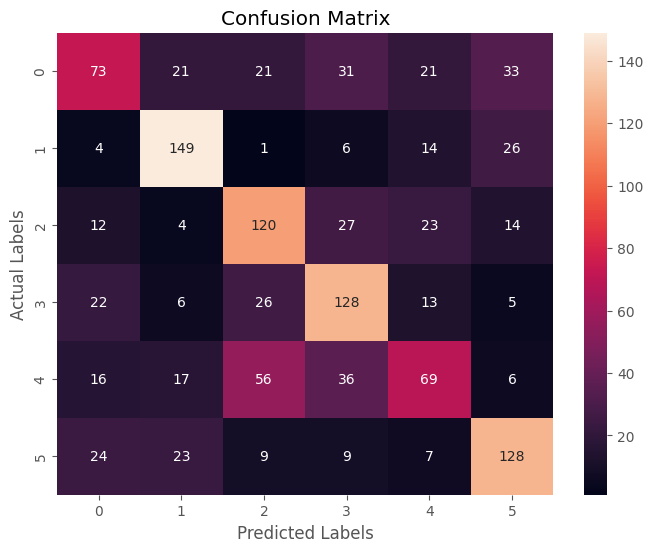

In [251]:
confusion = confusion_matrix(actual_labels, predicted_labels, labels=[i for i in range(6)])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', xticklabels=[i for i in range(6)], yticklabels=[i for i in range(6)])

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

plt.show()

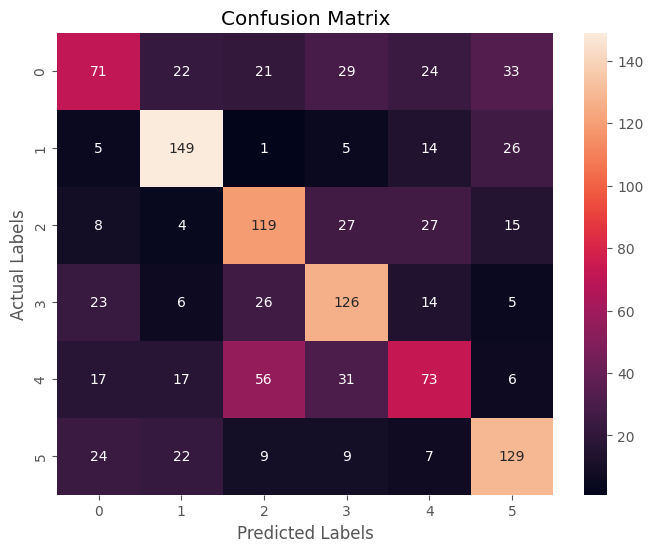

In [252]:
confusion = confusion_matrix(ski_actual_labels, ski_predictions, labels=[i for i in range(6)])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', xticklabels=[i for i in range(6)], yticklabels=[i for i in range(6)])


plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

plt.show()

## 5-Fold cross validation

In [253]:
X_multi_class = None
y = None

for i in range(0,num_classes):
    for iter, file in enumerate(glob.glob(f'./train/{i}/*.jpg')):
        if X_multi_class is None:
            X_multi_class = read_sample(file)
            y_multi_class = np.array([i])
        else:
            X_multi_class = np.vstack((X_multi_class, read_sample(file)))
            y_multi_class = np.hstack((y_multi_class, np.array([i])))

In [254]:
train_data_len = len(X_multi_class)
indices = np.arange(train_data_len)

np.random.shuffle(indices)

chunk_indices = np.array_split(indices, 5)

X_chunks = [X_multi_class[chunk] for chunk in chunk_indices]
y_chunks = [y_multi_class[chunk] for chunk in chunk_indices]

# X_multi_class = X_multi_class[indices]
# y_multi_class = y_multi_class[indices]

In [255]:

# five_fold_cross_validation_accuracy = []
# validation_accuracy = []

# values_of_c = [1e-5 , 1e-3, 1, 5, 10]

# for c in values_of_c:

def cross_validation_on_c(c,gamma = 0.01):
    
    
    
    five_fold_cross_validation_accuracy = []
    validation_accuracy = []
    
    for i in range(5):
        
        print(f"Running K-Fold with {c}, holding out chunk {i} for validation")
        
        X_init = None
        
        for j in range(5):
            if j == i:
                continue
            if X_init is None:
                X_init = X_chunks[j]
                y_init = y_chunks[j]
            else:
                X_init = np.vstack((X_init, X_chunks[j]))
                y_init = np.hstack((y_init, y_chunks[j]))

        ski_svm_gauss = svm.SVC(kernel='rbf', gamma=gamma, C=c, break_ties=True)
        ski_svm_gauss.fit(X_init,y_init)
        
        predictions = ski_svm_gauss.predict(X_chunks[i])
        correct  = 0
        total  = 0
        for prediction, actual in zip(predictions, y_chunks[i]):
            if prediction == actual:
                correct += 1
            total += 1    
            
        five_fold_cross_validation_accuracy.append((100*correct)/total)
        
        correct = 0
        total = 0
        for i in range(0,num_classes):
            for iter, file in enumerate(glob.glob(f'./val/{i}/*.jpg')):
                total += 1 
                validate_on = read_sample(file)
                if ski_svm_gauss.predict([validate_on]) == i:
                    correct += 1
        
        validation_accuracy.append(((100*correct)/total))
    
    five_fold_cross_validation_accuracy_mean = np.mean(np.array(five_fold_cross_validation_accuracy))
    validation_accuracy_mean = np.mean(np.array(validation_accuracy))
    five_fold_cross_validation_accuracy_max = max(five_fold_cross_validation_accuracy)
    validation_accuracy_max = max(validation_accuracy)
    
    return (five_fold_cross_validation_accuracy_mean, validation_accuracy_mean,five_fold_cross_validation_accuracy_max,validation_accuracy_max)

In [256]:
# values_of_c = [1e-5 , 1e-3, 1, 5, 10]

values_of_c = [10**x for x in range(-5,5)]

with concurrent.futures.ThreadPoolExecutor(max_workers=len(values_of_c)) as executor:
    results_on_c = list(executor.map(cross_validation_on_c, values_of_c))


Running K-Fold with 1e-05, holding out chunk 0 for validation
Running K-Fold with 0.0001, holding out chunk 0 for validation
Running K-Fold with 0.001, holding out chunk 0 for validation
Running K-Fold with 0.01, holding out chunk 0 for validation
Running K-Fold with 0.1, holding out chunk 0 for validation
Running K-Fold with 1, holding out chunk 0 for validation
Running K-Fold with 10, holding out chunk 0 for validation
Running K-Fold with 100, holding out chunk 0 for validation
Running K-Fold with 1000, holding out chunk 0 for validation
Running K-Fold with 10000, holding out chunk 0 for validation


Running K-Fold with 0.1, holding out chunk 1 for validation
Running K-Fold with 10000, holding out chunk 1 for validation
Running K-Fold with 1, holding out chunk 1 for validation
Running K-Fold with 100, holding out chunk 1 for validation
Running K-Fold with 10, holding out chunk 1 for validation
Running K-Fold with 1000, holding out chunk 1 for validation
Running K-Fold with 0.01, holding out chunk 1 for validation
Running K-Fold with 0.001, holding out chunk 1 for validation
Running K-Fold with 1e-05, holding out chunk 1 for validation
Running K-Fold with 0.0001, holding out chunk 1 for validation
Running K-Fold with 10000, holding out chunk 2 for validation
Running K-Fold with 10, holding out chunk 2 for validation
Running K-Fold with 0.1, holding out chunk 2 for validation
Running K-Fold with 100, holding out chunk 2 for validation
Running K-Fold with 1, holding out chunk 2 for validation
Running K-Fold with 1000, holding out chunk 2 for validation
Running K-Fold with 10, holding 

In [257]:
five_fold_cross_validation_accuracy = [v[0] for v in results_on_c]
validation_accuracy = [v[1] for v in results_on_c]
five_fold_cross_validation_accuracy_max = [v[2] for v in results_on_c]
validation_accuracy_max = [v[3] for v in results_on_c]

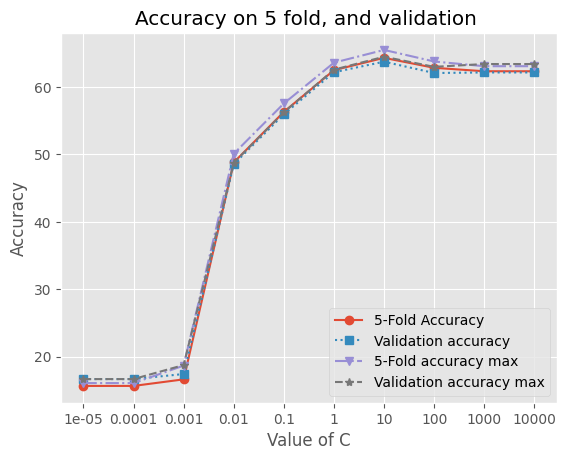

In [258]:
fig, ax = plt.subplots()
x_axis_at = [i for i in range(len(values_of_c))]

ax.plot(x_axis_at, five_fold_cross_validation_accuracy, label='5-Fold Accuracy', marker='o', linestyle='-')
ax.plot(x_axis_at, validation_accuracy, label='Validation accuracy', marker='s', linestyle=':')
ax.plot(x_axis_at, five_fold_cross_validation_accuracy_max, label='5-Fold accuracy max', marker='v', linestyle='-.')
ax.plot(x_axis_at, validation_accuracy_max, label='Validation accuracy max', marker='*', linestyle='--')

ax.set_xlabel('Value of C')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on 5 fold, and validation ')

ax.set_xticks(x_axis_at)
ax.set_xticklabels([str(c) for c in values_of_c])

ax.legend()

plt.grid(True)
plt.show()


In [259]:
# from functools import partial

# def run_for_given_gamma(gamma):
#     # values_of_c = [1e-5 , 1e-3, 1, 5, 10]

#     cross_validation_on_c_for_gamma = partial(cross_validation_on_c, gamma = gamma)

#     values_of_c = [10**x for x in range(-5,5)]
#     with concurrent.futures.ThreadPoolExecutor(max_workers=len(values_of_c)) as executor:
#         results_on_c = list(executor.map(cross_validation_on_c_for_gamma, values_of_c))
        
#     five_fold_cross_validation_accuracy = [v[0] for v in results_on_c]
#     validation_accuracy = [v[1] for v in results_on_c]
#     five_fold_cross_validation_accuracy_max = [v[2] for v in results_on_c]
#     validation_accuracy_max = [v[3] for v in results_on_c]
    
#     fig, ax = plt.subplots()
#     x_axis_at = [i for i in range(len(values_of_c))]

#     ax.plot(x_axis_at, five_fold_cross_validation_accuracy, label='5-Fold Accuracy', marker='o', linestyle='-')
#     ax.plot(x_axis_at, validation_accuracy, label='Validation accuracy', marker='s', linestyle=':')
#     ax.plot(x_axis_at, five_fold_cross_validation_accuracy_max, label='5-Fold accuracy max', marker='v', linestyle='-.')
#     ax.plot(x_axis_at, validation_accuracy_max, label='Validation accuracy max', marker='*', linestyle='--')

#     ax.set_xlabel('Value of C')
#     ax.set_ylabel('Accuracy')
#     ax.set_title(f'Accuracy on 5 fold, and validation for gamma = {gamma} ')

#     ax.set_xticks(x_axis_at)
#     ax.set_xticklabels([str(c) for c in values_of_c])

#     ax.legend()

#     plt.grid(True)
#     plt.show()
    
#     return []



In [260]:
# values_of_gamma = [10**x for x in range(-5,5)]

# with concurrent.futures.ThreadPoolExecutor(max_workers=len(values_of_gamma)) as executor:
#     results_on_c = list(executor.map(run_for_given_gamma, values_of_gamma))